<a href="https://colab.research.google.com/github/Katya0208/Sirius_project/blob/main/ResNet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import h5py
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
from skimage import io, transform
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from random import randrange, uniform

from torchvision import transforms

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [ ]:
class myDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.file = dict(h5py.File(root_dir, 'r'))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file['X_train'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.file['X_train'][idx]
        image = PIL.Image.fromarray(image).convert('RGB')
        label = self.file['Y_train'][idx]
        
        if self.transform is not None:
            image = self.transform(image)

        return (image, label.astype(np.int64))

In [ ]:
traindir = '/content/drive/MyDrive/Sirius.Retina/01_04/only_retina.h5'
testdir = '/content/drive/MyDrive/Sirius.Retina/01_04/only_retina_test.h5'
path_to_save = '/content/drive/MyDrive/Sirius.Retina/01_04/resnet50v2'

mean = 0.5444
var = 0.4022

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(brightness=.20, contrast=.20),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),  
        # transforms.Normalize(mean=[mean, mean, mean], std=[var, var, var])  
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.ToTensor(),  
        transforms.Normalize(mean=[mean, mean, mean], std=[var, var, var])  
    ]),

    'test':
    transforms.Compose([
        transforms.ToTensor(),  
        transforms.Normalize(mean=[mean, mean, mean], std=[var, var, var])   
    ]),
}

data = {
    'train':
    myDataset(traindir, transform=image_transforms['train']),
    'valid':
    myDataset(traindir, transform=image_transforms['valid']),
    'test':
    myDataset(testdir, transform=image_transforms['test']),
}

data['train'][0][0].shape
len(data['test'])

238

1               1               1               1               1               1               1               1               1               0               

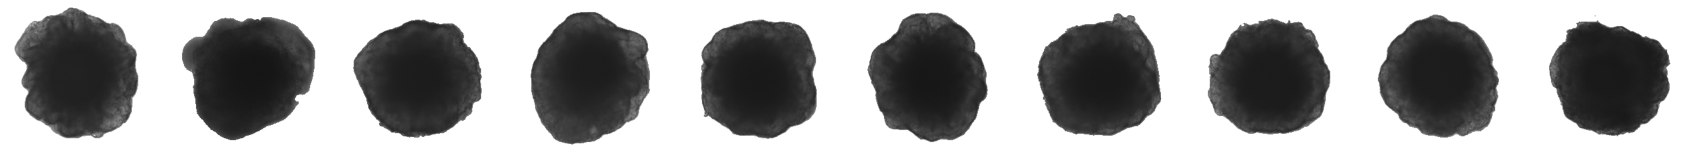

In [ ]:
plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data['train']):
    if i == 10:
      break
    print(y, end='               ')
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x.permute(1, 2, 0))
    plt.axis('off')

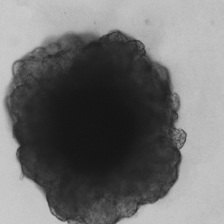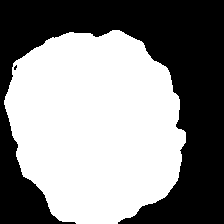

In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(data['valid'], batch_size=batch_size,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(data['test'], batch_size=batch_size,
                                         shuffle=True)

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

4
4
1


In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [ ]:
nn_model = models.wide_resnet50_2(pretrained=True)
# Freeze model weights
for param in nn_model.parameters():
    param.requires_grad = False

# nn_model.parameters

# for param in nn_model.parameters():
#     print(param.requires_grad)

In [ ]:
# Add on classifier
nn_model.fc = nn.Sequential(
                      nn.Linear(2048, 512), 
                      nn.BatchNorm1d(512),
                      nn.ReLU(), 
                      nn.Dropout(0.8),
                      nn.Linear(512, 2),                   
                      nn.LogSoftmax(dim=1)
                      )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters())

In [ ]:
# nn_model.parameters

In [ ]:
def ROC_AUC(model, loader):
    model.eval() # Evaluation mode
    res = []
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        prediction = model(x_gpu)   
        m = nn.Softmax(dim=1)
        prediction = m(prediction) 
        res += [roc_auc_score(y.detach().numpy(), prediction[:, 1].to(torch.device('cpu')).detach().numpy())]
        
    return np.mean(res)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    
    n_epochs_stop = 50
    max_val_accuracy = -np.Inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = ROC_AUC(model, val_loader)

        if val_accuracy > max_val_accuracy:
        # Save the model
          torch.save(model, path_to_save)
          epochs_no_improve = 0
          max_val_accuracy = val_accuracy  
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("№%.0f, No improve №%.0f, Max val accuracy: %f \nAverage loss: %f, Train accuracy: %f, Val accuracy: %f\n" 
              % (epoch+1, epochs_no_improve+1, max_val_accuracy, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 500)

# Load in the best model
nn_model = torch.load(path_to_save)

№1, No improve №1, Max val accuracy: 0.675317 
Average loss: 0.870937, Train accuracy: 0.650526, Val accuracy: 0.675317

№2, No improve №1, Max val accuracy: 0.730127 
Average loss: 0.724285, Train accuracy: 0.770526, Val accuracy: 0.730127

№3, No improve №1, Max val accuracy: 0.755146 
Average loss: 0.692236, Train accuracy: 0.775789, Val accuracy: 0.755146

№4, No improve №1, Max val accuracy: 0.762937 
Average loss: 0.717274, Train accuracy: 0.771579, Val accuracy: 0.762937

№5, No improve №2, Max val accuracy: 0.762937 
Average loss: 0.668339, Train accuracy: 0.768421, Val accuracy: 0.745236

№6, No improve №3, Max val accuracy: 0.762937 
Average loss: 0.637567, Train accuracy: 0.776842, Val accuracy: 0.732508

№7, No improve №4, Max val accuracy: 0.762937 
Average loss: 0.639873, Train accuracy: 0.788421, Val accuracy: 0.724048

№8, No improve №5, Max val accuracy: 0.762937 
Average loss: 0.613595, Train accuracy: 0.775789, Val accuracy: 0.723796

№9, No improve №6, Max val accur

In [ ]:
nn_model = torch.load(path_to_save)

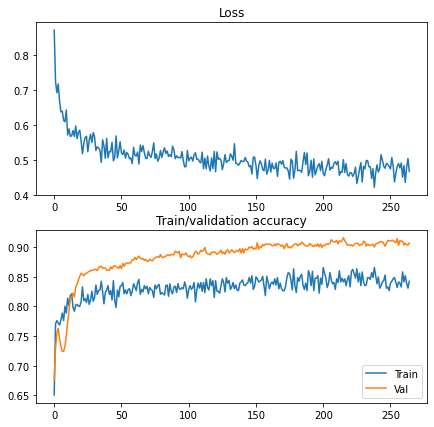

In [ ]:
plt.figure(figsize=(7, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history, label="Train")
plt.plot(val_history,label="Val")
plt.legend()
plt.show()

In [ ]:
def plot_ROC(model, loader):
    model.eval() # Evaluation mode
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        prediction = model(x_gpu)   
        m = nn.Softmax(dim=1)
        prediction = m(prediction)  
    
    lr_fpr, lr_tpr, _ = roc_curve(y.detach().numpy(), prediction[:, 1].to(torch.device('cpu')).detach().numpy())
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

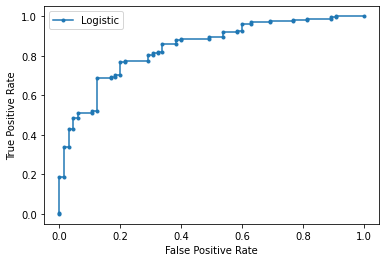

In [ ]:
len(test_loader)

res = ROC_AUC(nn_model, test_loader)

plot_ROC(nn_model, test_loader)

In [ ]:
res

0.8421520675855936

https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/